# Create multliayer Food groups 
It is a copy of Multilayer food_groups.ipynb but that I am going to mess-up to tranform into a code that I can apply to make trajectories of a country across the years

In [ ]:
import pandas as pd
import numpy as np
import time
import networkx as nx
#import geopandas as gpd # pip installed
import matplotlib.pyplot as plt 
import pickle
from tqdm import tqdm
import seaborn as sns
from matplotlib.colors import ListedColormap


In [3]:
# FUNCTION DEFINITION:
def Food_group_sum (data, f_group):
    filt_data= data.loc[data.Food_group == f_group,:]
    data_grouped= filt_data.groupby(['Food_group','unit','origin_country','destin_country','year'])
    filt_data.loc[:,'value']= data_grouped.value.transform('sum')

    filt_data.loc[:,'item']= f_group
    return(filt_data)

def FoodEx_aggregation(data_trade,group_class):
    if group_class == 'Food_group':
        data_trade_filt = data_trade.drop(columns=['item','item_code'])
        data_trade_filt = data_trade_filt.groupby(by=['origin_country_ISO','destin_country_ISO','year','L1_foodex','Food_group','unit','origin_country','destin_country'],as_index=False).sum()
        data_trade_filt.reset_index(drop=True,inplace=True)
    else: 
        data_trade_filt = data_trade.copy(deep=True)
        data_trade_filt.drop(columns=['L1_foodex','Food_group'],inplace=True)
    return data_trade_filt

def Node_strength(data, direction, group_class, weight = True):
    """ Calculate the node relevance in each layer of the multilayer network. 
    In a weighted directed network the country strenght is the sum of the magnitude exported by that country in that layer.

    Parameters:
    - data (pd.DataFrame): Input DataFrame containing trade data for a single year. The dataframe must contain 
    the columns: 'item', 'unit', 'origin_country_ISO', and 'value'.

    Returns:
    pd.DataFrame: DataFrame with country strength for each combination of 'item' and 'unit', sorted from highest to lowest. 
    Columns include 'item', 'unit', 'origin_country_ISO', and the calculated 'value' for node strength.

    Example:
    >>> df_result = Node_strength_w(input_data)
    """

    if direction == 'out':
        country_group = 'origin_country_ISO'
    else: 
        country_group = 'destin_country_ISO'

    if (weight==True):
        str_i_l = data.groupby([group_class,'unit'])[[country_group,'value']].apply(lambda group: group.
                                                        pivot_table(index=country_group, aggfunc='sum').
                                                        sort_values(by = 'value',ascending=False))
        strength_i_l= str_i_l.reset_index(level=[group_class,'unit',country_group]).rename(columns={'value':'str_i_l'})

    else:
        str_i_l = data.groupby([group_class,'unit'])[[country_group,'value']].apply(lambda group: group.
                                                        pivot_table(index=country_group, aggfunc=lambda x: len(x)).
                                                        sort_values(by = 'value',ascending=False))
        strength_i_l= str_i_l.reset_index(level=[group_class,'unit',country_group]).rename(columns={'value':'str_i_l'})

    return strength_i_l

def Participation_coeff (data, overlap, direction, group_class, weight):

    if (weight == True):
        w_f = '_w'
        flag_overlap = 'overl'
    else:
        w_f = ''
        flag_overlap = 'deg'

    if direction == 'out':
        country_group = 'origin_country_ISO'
    else: 
        country_group = 'destin_country_ISO'
    #Define elements for part_coeff
    L = len(data[group_class].unique()) # Number of layers
    
    s_i_l = Node_strength(data, direction, group_class,weight)

    # Prepare data
    #data_for_Pc = pd.merge(s_i_l, o_i, left_on= 'origin_country_ISO',right_index=True, how='left')
    data_for_Pc = pd.merge(s_i_l, overlap.loc[:,['country',direction+'_'+flag_overlap]], left_on= country_group,right_on='country', how='left')

    # Contibution of each layer to total exports:
    data_for_Pc['sum_layers'] = (data_for_Pc['str_i_l']/data_for_Pc[direction+'_'+flag_overlap])**2
    
    sum_layers= data_for_Pc.groupby([country_group]).sum_layers.apply(lambda group: group.sum())

    particip_coeff = pd.DataFrame((L/(L-1))*(1- sum_layers)).rename(columns={'sum_layers':'pc'+w_f+'_'+direction})
    particip_coeff = particip_coeff.sort_values(by='pc'+w_f+'_'+direction,ascending=False)
    
    return particip_coeff 

def Agregated_network (edge_data,node_info, group_class):
    
    # General network 
    pos_dict = node_info.loc[:,['ISO3 Code','pos','Country']].set_index('ISO3 Code').to_dict(orient='index')
    pos_dict

    edge_dict =dict(zip(zip(edge_data['origin_country_ISO'], edge_data['destin_country_ISO'], edge_data[group_class]), edge_data['value']))
    edge_dict

    # Create network
    G=nx.MultiDiGraph()

    G.add_nodes_from(pos_dict)
    nx.set_node_attributes(G,pos_dict)

    G.add_edges_from(edge_dict.keys())
    nx.set_edge_attributes(G, edge_dict, 'weight')
    nx.set_edge_attributes(G, edge_dict.keys(), '<attribute_name>')
    return G
        
def Make_dict_years (data_in, country_metadata, direction, group_class, year_check,unit_flag):
    """ 
    Iterate everything to filter data per year, get network and network stats. 
    The output should be a the dataframe with the value of overlap and zscore for each country the year being explored. 

    This will be saved in a dictionary. 
    """
    if unit_flag== 'dollars':
        unit_val = '1000 USD'
    else:
        unit_val = unit_flag
    
    #Load data 
    data_filt = data_in.loc[(data_in.unit ==unit_val) & (data_in.year == year_check) & (data_in.value > 0) ,:].copy()
    # Create agregated multilayer network 
    G = Agregated_network(data_filt, country_metadata, group_class = group_class)

    # Degree estimations
    out_degree= pd.DataFrame([i for i in G.out_degree()],columns=['country','out_deg']).sort_values(by='out_deg',ascending=False)
    in_degree= pd.DataFrame([i for i in G.in_degree()],columns=['country','in_deg']).sort_values(by='in_deg',ascending=False)

    # Overlap: sum of weights (out_degree)
    overlap= pd.DataFrame([i for i in G.out_degree(weight='weight')],columns=['country','out_overl']).sort_values(by='out_overl',ascending=False)
    in_overlap= pd.DataFrame([i for i in G.in_degree(weight='weight')],columns=['country','in_overl']).sort_values(by='in_overl',ascending=False)

    overlap= pd.merge(overlap,in_overlap, on='country', copy=False)
    overlap= pd.merge(overlap,out_degree, on='country', copy=False)
    overlap= pd.merge(overlap,in_degree, on='country', copy=False)

    # Add z score degree and overlap:
    overlap['z_'+direction+'_deg'] = (overlap[direction+'_deg'] - overlap[direction+'_deg'].mean())/overlap[direction+'_deg'].std()

    overlap['z_'+direction+'_overl'] = (overlap[direction+'_overl'] - overlap[direction+'_overl'].mean()) / overlap[direction+'_overl'].std()

    # Participation coefficient: 
    partic_coeff = Participation_coeff(data_filt, overlap, direction, group_class,weight=False)
    partic_coeff_w = Participation_coeff(data_filt, overlap, direction,group_class,weight=True)
    partic_coeff = pd.merge(partic_coeff, partic_coeff_w, left_index=True, right_index=True,how='left')

    # Merge participation and degree dataframes:
    deg_particip = pd.merge(overlap, partic_coeff, right_index=True, left_on='country',how='left')
    return deg_particip


In [4]:
#year_check= 2019 #'1986-1988'#2019
direction = 'out'
group_class = 'Food_group' # item
unit_flag = 'dollars' # tonnes

country_metadata = pd.read_csv('../Data/intermediate/Country_info_metadata.csv')

data_og = pd.read_csv('../Data/intermediate/Data_trade_clean.csv') #Data/Data_trade_filt_production.pkl #Data_food_groups_code.pkl

In [5]:
# Agregate data in the selected group_class: 
data_agg = FoodEx_aggregation(data_og,group_class)

Iterate estimation for all countries and years. It is saved as a dictionary with a single pandas datafarame containing all outputs. 

In [5]:
list_years = data_agg.year.unique()

dict_results_in = dict((i, Make_dict_years(data_agg,country_metadata, 'in', group_class,i, unit_flag)) for i in tqdm(list_years))
dict_results_out = dict((i, Make_dict_years(data_agg,country_metadata, 'out', group_class,i, unit_flag)) for i in tqdm(list_years))

pickle.dump(dict_results_in, open('../Data/intermediate/particip_overlap/in_overlap_particip_'+unit_flag+'_'+group_class+'.pkl', 'wb'))
pickle.dump(dict_results_out, open('../Data/intermediate/particip_overlap/out_overlap_particip_'+unit_flag+'_'+group_class+'.pkl', 'wb'))


  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████| 37/37 [00:16<00:00,  2.18it/s]


## Plots exports and imports

Data_loaded


/tmp/ipykernel_401868/2070615010.py:120: MatplotlibDeprecationWarning: Passing label as a length 37 sequence when plotting a single dataset is deprecated in Matplotlib 3.9 and will error in 3.11.  To keep the current behavior, cast the sequence to string before passing.
  ax.plot(coords['pc'+w_f+'_'+direction], coords['z_'+direction+'_'+flag_overlap],zorder = 3,label= coords.index,color ='darkgrey',linewidth=0.8)
/tmp/ipykernel_401868/2070615010.py:96: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  multi_hubs_list.fillna(0,inplace=True)
/tmp/ipykernel_401868/2070615010.py:120: MatplotlibDeprecationWarning: Passing label as a length 37 sequence when plotting a single dataset is deprecated in Matplotlib 3.9 and will error in 3.11.  To keep the current behavior, cast the se

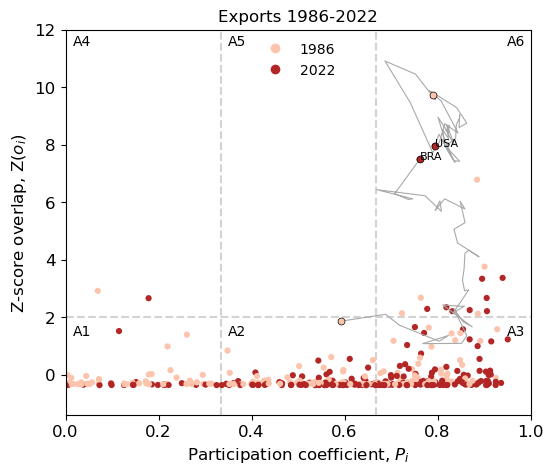

In [8]:
from matplotlib.lines import Line2D

# need to do dynamic
def Country_map_static_ColorAll (dict_results, parameters, country_list, year_plot= 'All', plt_flag=True, flag_annot ='Multi_hubs',trace_countries= [None]):
    
    if (parameters['weight'] == True):
        w_f = '_w'
        flag_overlap = 'overl'
        title_overlap = r'overlap, Z($o_i$)'
    else:
        w_f = ''
        flag_overlap = 'deg'
        title_overlap = 'degree'
    
    # Define start for All flags
    if country_list == 'All':
        country_list = list(dict_results[list(dict_results.keys())[0]].country)
        title_year = 'for all countries'
    else: 
        title_year  = country_list
    

    if len(year_plot) == 1:
        title_year = year_plot[0]
        colors= ['#b32626']

    else:
        year_plot = sorted(year_plot)
        title_year  = str(min(year_plot))+'-'+str(max(year_plot))

    if len(year_plot) == 2:
        colors= ['#FCC4AD','#b32626']
        c_count = 0
    
    if direction == 'in':
        dir_title = 'Imports'
        A3_xpos= 0.7
        y_pos=11.4
    else: 
        dir_title = 'Exports'
        A3_xpos= 0.97
        y_pos=11.6


    year_list= sorted(list(set(dict_results.keys())))# # 2020 and 2021 removed due to COVID-19 impact on trade data


    # Define figure characteristics 
    if plt_flag == True :
        maxY_plot = max([max(dict_results[y]['z_'+ direction+'_'+flag_overlap]) for y in year_list])
        minY_plot = min([min(dict_results[y]['z_'+ direction+'_'+flag_overlap]) for y in year_list])

        fig_phase, ax = plt.subplots(figsize = (6,5))
        ax.axvline(x=1/3, color='darkgrey', linestyle= '--', zorder =0,alpha=0.5)
        ax.axvline(x=2/3, color='darkgrey', linestyle= '--', zorder = 0,alpha=0.5)
        ax.axhline(y=2, color='darkgrey', linestyle= '--', zorder = 0,alpha=0.5)
        ax.set_xlim (0,1)
        ax.set_xlim (0,1)
        ax.set_ylim((minY_plot-1,maxY_plot+1))
        #ax.set_ylim((minY_plot-1,8))#maxY_plot+0.5))
        #
        ax.set_ylabel('Z-score ' + title_overlap ,fontsize=12)
        ax.set_xlabel(r'Participation coefficient, $P_i$',fontsize=12)
        ax.tick_params(axis='both', which='major', labelsize=12)

        ax.set_title(f'{dir_title} {title_year}',fontsize=12)

        ##ax.set_title ('Map with weighted overlap: '+ str(title_country) +' countries' +' & '+ str(title_year))
        #ax.set_title ('Relevance in global food trade '+dir_title +': '+ str(title_country) +' & '+ str(title_year))

    # Iterate for countries:
    coords_dict = dict()
    multi_hubs_list=pd.DataFrame(columns=year_list)
    # Add sectors 
    ax.annotate('A1', xy=(0.035, 1.5),fontsize=10, color='black',ha='center', va='center')
    ax.annotate('A2', xy=(0.37, 1.5),fontsize=10, color='black',ha='center', va='center')
    ax.annotate('A3', xy=(A3_xpos, 1.5),fontsize=10, color='black',ha='center', va='center')
    ax.annotate('A4', xy=(0.035, y_pos),fontsize=10, color='black',ha='center', va='center')
    ax.annotate('A5', xy=(0.37, y_pos),fontsize=10, color='black',ha='center', va='center')
    ax.annotate('A6', xy=(0.97, y_pos),fontsize=10, color='black',ha='center', va='center')

    for country in country_list:
        coords = pd.DataFrame()
        for y in year_list:
            to_add = dict_results[y].loc[(dict_results[y]['country']==country),('pc'+w_f+'_'+direction,'z_'+direction+'_'+flag_overlap)] 
            #to_add['country'] =  [pycountry.countries.get(alpha_2= c).alpha_3 for c in to_add.country]
            coords = pd.concat([coords,to_add])
        coords.index = year_list

        coords_dict[country] = coords
        
        # Save how often a country is a multihub: 
        multi_hubs = coords.loc[(coords['pc_w_'+direction]>=2/3) & (coords['z_'+direction+'_overl']>=2),:]
        if (len(multi_hubs)>0):
            multi_hubs_list.loc[country,multi_hubs.index] = 1# save how often are they multihubs
            multi_hubs_list.fillna(0,inplace=True)
        
        # Plot
        if (plt_flag ==True): 
            if (len(year_plot) <=2):
                c_count = 0
                for y in year_plot:
                    ax.scatter(coords['pc'+w_f+'_'+direction].loc[y], coords['z_'+direction+'_'+flag_overlap].loc[y],zorder = 1,label= y,color = colors[c_count],alpha=1,s=20,edgecolors='None')
                    c_count += 1
                    #.scatter(coords['pc'+w_f+'_'+direction].iloc[-1], coords['z_'+direction+'_'+flag_overlap].iloc[-1],zorder = 2,label= coords.index[-1],color = colors[c_count])
                #c_count += 1
            else: 
                ax.plot(coords['pc'+w_f+'_'+direction], coords['z_'+direction+'_'+flag_overlap],zorder = 2,label= coords.index,color ='lightgray')
                ax.scatter(coords['pc'+w_f+'_'+direction].iloc[1:-1], coords['z_'+direction+'_'+flag_overlap].iloc[1:-1],zorder = 2,s=8,label= coords.index,color ='lightgray')
                ax.scatter(coords['pc'+w_f+'_'+direction].iloc[0], coords['z_'+direction+'_'+flag_overlap].iloc[0],zorder = 2,label= coords.index[0],s=8,color = '#b32626')# black
                ax.scatter(coords['pc'+w_f+'_'+direction].iloc[-1], coords['z_'+direction+'_'+flag_overlap].iloc[-1],zorder = 2,label= coords.index[-1],color = '#b32626',marker='x')

            if (flag_annot =='Multi_hubs') & (len(multi_hubs)>0):
                ax.annotate(country,(multi_hubs['pc'+w_f+'_'+direction].iloc[-1], multi_hubs['z_'+direction+'_'+flag_overlap].iloc[-1]),zorder = 2,label= multi_hubs.index[-1],color = 'black',fontsize=10)
            elif (flag_annot =='All'):
                ax.annotate(country,(coords['pc'+w_f+'_'+direction].iloc[-1], coords['z_'+direction+'_'+flag_overlap].iloc[-1]),zorder = 2,label= coords.index[-1],color = 'black')

            if country in trace_countries: 
                c_count=0
                ax.plot(coords['pc'+w_f+'_'+direction], coords['z_'+direction+'_'+flag_overlap],zorder = 3,label= coords.index,color ='darkgrey',linewidth=0.8)
                for y in year_plot:
                    ax.scatter(coords['pc'+w_f+'_'+direction].loc[y], coords['z_'+direction+'_'+flag_overlap].loc[y],zorder = 3,label= y,color = colors[c_count],alpha=1,s=25,edgecolors='black',linewidths=0.5)
                    c_count += 1
                ax.annotate(country,(coords['pc'+w_f+'_'+direction].iloc[-1], coords['z_'+direction+'_'+flag_overlap].iloc[-1]),zorder = 3,color = 'black',fontsize=8)

        # Add manual legend with red and pink point 
        legend_elements = [Line2D([0], [0], marker='o', label=str(year),
                                markerfacecolor=colors[c], color='w',markersize=8) for c,year in enumerate(year_plot)]
        ax.legend(handles=legend_elements, loc='upper center', fontsize=10,frameon=False)
        ax.set_ylim(ymax=12)

    # Save figur
    fig_phase.savefig('../Plots/2023/Plane_OverlapParticipation_'+dir_title+'_'+parameters['flag_unit']+'.pdf',format ='pdf',dpi=300)   
    plt.show()
    #print(country)
    return coords_dict, multi_hubs_list


# Coords dict 
weight =True
group_class = 'Food_group'#'Food_group'
direction = 'out'
flag_unit = 'dollars'#'dollars
trace_countries = ['USA','BRA']

with open('../Data/intermediate/particip_overlap/'+direction+'_overlap_particip_'+flag_unit+'_'+group_class+'.pkl', 'rb') as f:
    print('Data_loaded')
    dict_results = pickle.load(f)
    
list_years = dict_results.keys()

parameters = {'group_class':group_class, 'direction': direction,'weight':weight,'flag_unit':flag_unit}
coords_dict, multi_hubs_list_out = Country_map_static_ColorAll(dict_results,parameters, country_list='All',year_plot=[1986,2022],plt_flag = True, flag_annot=None,trace_countries= trace_countries)


In [9]:



#fig_multi, ax= plt.subplots(1,figsize=(10,4))
multi_hubs_list_out['rowsum']=multi_hubs_list_out.sum(axis=1)
multi_hubs_list_out.sort_values(by='rowsum',ascending=False,inplace=True)
multi_hubs_list_out.drop(columns='rowsum',inplace=True)

'''
# Assuming colors is your list of colors
colors = [ "#D3D3D3","#b32626"]
cmap = ListedColormap(colors)

sns.heatmap(multi_hubs_list_out, cmap=cmap,ax=ax) 

# Manually specify colorbar labelling after it's been generated
colorbar = ax.collections[0].colorbar
colorbar.set_ticks([0.2, 0.8])

labels = [str(year) if year in multi_hubs_list_out.columns[::5] else '' for year in multi_hubs_list_out.columns]
ax.set_xticklabels(labels)

colorbar.set_ticklabels(['Not a multilayer hub','Multilayer hub'])
ax.set_title('Multiproduct hubs - Exports')
fig_multi.savefig('../Plots/2023/multihub_'+direction+'.pdf',format ='pdf',dpi=300)'''

'\n# Assuming colors is your list of colors\ncolors = [ "#D3D3D3","#b32626"]\ncmap = ListedColormap(colors)\n\nsns.heatmap(multi_hubs_list_out, cmap=cmap,ax=ax) \n\n# Manually specify colorbar labelling after it\'s been generated\ncolorbar = ax.collections[0].colorbar\ncolorbar.set_ticks([0.2, 0.8])\n\nlabels = [str(year) if year in multi_hubs_list_out.columns[::5] else \'\' for year in multi_hubs_list_out.columns]\nax.set_xticklabels(labels)\n\ncolorbar.set_ticklabels([\'Not a multilayer hub\',\'Multilayer hub\'])\nax.set_title(\'Multiproduct hubs - Exports\')\nfig_multi.savefig(\'../Plots/2023/multihub_\'+direction+\'.pdf\',format =\'pdf\',dpi=300)'

Data_loaded


/tmp/ipykernel_401868/2070615010.py:120: MatplotlibDeprecationWarning: Passing label as a length 37 sequence when plotting a single dataset is deprecated in Matplotlib 3.9 and will error in 3.11.  To keep the current behavior, cast the sequence to string before passing.
  ax.plot(coords['pc'+w_f+'_'+direction], coords['z_'+direction+'_'+flag_overlap],zorder = 3,label= coords.index,color ='darkgrey',linewidth=0.8)
/tmp/ipykernel_401868/2070615010.py:120: MatplotlibDeprecationWarning: Passing label as a length 37 sequence when plotting a single dataset is deprecated in Matplotlib 3.9 and will error in 3.11.  To keep the current behavior, cast the sequence to string before passing.
  ax.plot(coords['pc'+w_f+'_'+direction], coords['z_'+direction+'_'+flag_overlap],zorder = 3,label= coords.index,color ='darkgrey',linewidth=0.8)
/tmp/ipykernel_401868/2070615010.py:96: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. C

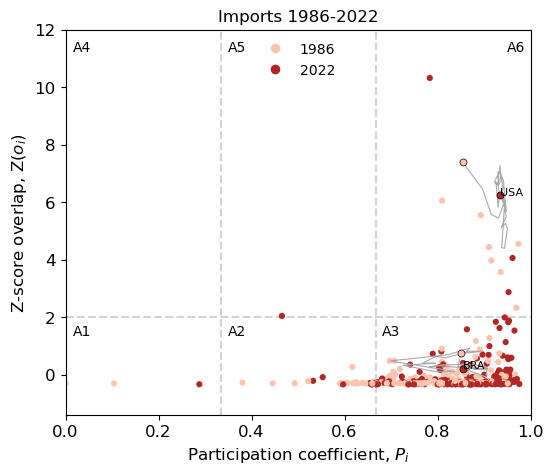

In [10]:

# Coords dict 
weight =True
group_class = 'Food_group'#'Food_group'
direction = 'in'
flag_unit = 'dollars'#'dollars
trace_countries = ['USA','BRA']

with open('../Data/intermediate/particip_overlap/'+direction+'_overlap_particip_'+flag_unit+'_'+group_class+'.pkl', 'rb') as f:
    print('Data_loaded')
    dict_results = pickle.load(f)
    
list_years = dict_results.keys()

parameters = {'group_class':group_class, 'direction': direction,'weight':weight,'flag_unit':flag_unit}
coords_dict, multi_hubs_list = Country_map_static_ColorAll(dict_results,parameters, country_list='All',year_plot=[1986,2022],plt_flag = True, flag_annot=None,trace_countries= trace_countries)


In [11]:

#fig_multi, ax= plt.subplots(1,figsize=(10,4))
multi_hubs_list['rowsum']=multi_hubs_list.sum(axis=1)
multi_hubs_list.sort_values(by='rowsum',ascending=False,inplace=True)
multi_hubs_list.drop(columns='rowsum',inplace=True)
multi_hubs_list
'''
# Assuming colors is your list of colors
colors = [ "#D3D3D3","#b32626"]
cmap = ListedColormap(colors)

sns.heatmap(multi_hubs_list, cmap=cmap,ax=ax) 

# Manually specify colorbar labelling after it's been generated
colorbar = ax.collections[0].colorbar
colorbar.set_ticks([0.2, 0.8])
colorbar.set_ticklabels(['Not a multilayer b','Multilayer hub'])
ax.set_title('Multilayer hubs - Imports')
# show xticks for every 5 years place ticks in the center 
labels = [str(year) if year in multi_hubs_list.columns[::5] else '' for year in multi_hubs_list.columns]
ax.set_xticklabels(labels)

#ax.set_xticks(np.arange(0, len(multi_hubs_list.columns), 5))
#ax.set_xticklabels(multi_hubs_list.columns[::5]
fig_multi.savefig('../Plots/2023/multihub_'+direction+'.pdf',format ='pdf',dpi=300)'''

'\n# Assuming colors is your list of colors\ncolors = [ "#D3D3D3","#b32626"]\ncmap = ListedColormap(colors)\n\nsns.heatmap(multi_hubs_list, cmap=cmap,ax=ax) \n\n# Manually specify colorbar labelling after it\'s been generated\ncolorbar = ax.collections[0].colorbar\ncolorbar.set_ticks([0.2, 0.8])\ncolorbar.set_ticklabels([\'Not a multilayer b\',\'Multilayer hub\'])\nax.set_title(\'Multilayer hubs - Imports\')\n# show xticks for every 5 years place ticks in the center \nlabels = [str(year) if year in multi_hubs_list.columns[::5] else \'\' for year in multi_hubs_list.columns]\nax.set_xticklabels(labels)\n\n#ax.set_xticks(np.arange(0, len(multi_hubs_list.columns), 5))\n#ax.set_xticklabels(multi_hubs_list.columns[::5]\nfig_multi.savefig(\'../Plots/2023/multihub_\'+direction+\'.pdf\',format =\'pdf\',dpi=300)'

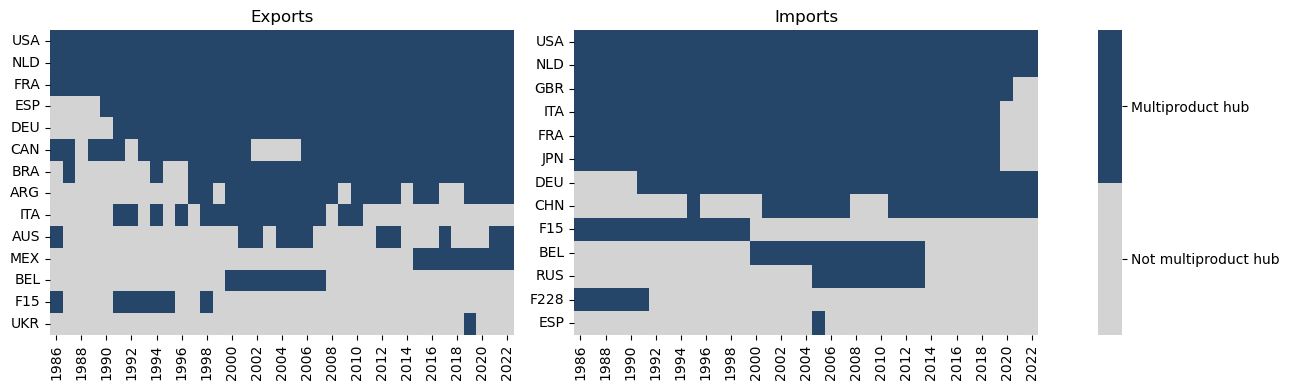

In [13]:
# join two figures in subplot
fig_multi, ax= plt.subplots(1,3,figsize=(13,4),gridspec_kw={'width_ratios': [1, 1, 0.05]})

# Assuming colors is your list of colors
colors = [ "lightgray","#254668"]
cmap = ListedColormap(colors)

# Output
multi_hubs_list_out['rowsum']=multi_hubs_list_out.sum(axis=1)
multi_hubs_list_out.sort_values(by='rowsum',ascending=False,inplace=True)
multi_hubs_list_out.drop(columns='rowsum',inplace=True)

sns.heatmap(multi_hubs_list_out, cmap=cmap,ax=ax[0],cbar=False) 

labels = [str(year) if year in multi_hubs_list_out.columns[::5] else '' for year in multi_hubs_list_out.columns]
#ax[0].set_xticklabels(labels)

# In
multi_hubs_list['rowsum']=multi_hubs_list.sum(axis=1)
multi_hubs_list.sort_values(by='rowsum',ascending=False,inplace=True)
multi_hubs_list.drop(columns='rowsum',inplace=True)
multi_hubs_list

hm = sns.heatmap(multi_hubs_list, cmap=cmap, ax=ax[1], cbar=False)

# --- Manual colorbar on ax[2] ---
cbar = fig_multi.colorbar(hm.collections[0], cax=ax[2])
#remove edgecolor in cbar
cbar.outline.set_edgecolor('none')
cbar.set_ticks([0.25, 0.75])
cbar.set_ticklabels(['Not multiproduct hub', 'Multiproduct hub'])

# put colorbar of ax1 in ax2

ax[1].set_title('Imports')
ax[0].set_title('Exports')
plt.tight_layout()
fig_multi.savefig('../Plots/2023/multihub_in_out.pdf',format ='pdf',dpi=300)

In [77]:
# count years multihub
multi_hub_years = multi_hubs_list_out.sum(axis=1)

In [79]:
multi_hub_years


USA    37.0
NLD    37.0
FRA    37.0
ESP    33.0
DEU    32.0
CAN    31.0
BRA    28.0
ARG    21.0
ITA    16.0
AUS    11.0
MEX     8.0
BEL     8.0
F15     7.0
UKR     1.0
dtype: float64

In [73]:
7/len(multi_hub_years)

0.5384615384615384

In [74]:
multi_hub_years = multi_hubs_list.sum(axis=1)

In [75]:
multi_hub_years.quantile(0.5)

np.float64(32.0)

In [76]:
32/37

0.8648648648648649